In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 11 16:42:10 2023

@author: konstantinos
"""

"""
Created on Mon Oct 9 2023

@author: konstantinos, paola 

Calculate the luminosity that we will use in the blue (BB) curve as sum of multiple BB.

NOTES FOR OTHERS:
- All the functions have to be applied to a CELL
- arguments are in cgs, NOT in log.
- make changes in VARIABLES: frequencies range, fixes (number of snapshots) anf thus days
"""

# Vanilla imports
import numpy as np
import matplotlib.pyplot as plt
AEK = '#F1C410'

# Chocolate imports
from src.Calculators.ray_maker import ray_maker
from src.Luminosity.thermR import get_thermr
from src.Opacity.opacity_table import opacity

# Constants
c = 2.99792458e10 #[cm/s]
h = 6.62607015e-27 #[gcm^2/s]
Kb = 1.380649e-16 #[gcm^2/s^2K]
alpha = 7.5646 * 10**(-15) # radiation density [erg/cm^3K^4]
Rsol_to_cm = 6.957e10
#%%
###
# FUNCTIONS
###

def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr

def select_fix(m):
    if m == 4:
        snapshots = [233, 254, 263, 277 , 293, 308, 322]
        days = [1, 1.2, 1.3, 1.4, 1.56, 1.7, 1.8] 
    if m == 6:
        snapshots = [881]#[881, 950, 993]
        days = [1.1]#[1.1, 1.4, ?] #t/t_fb
    return snapshots, days

def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency. """
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)

    return fun

def luminosity_n(Temperature: float, Density: float, tau: float, volume: float, n: float):
    """ Luminosity in a cell: L_ni = \epsilon e^(-\tau) B_ni / B where  
    B = \sigma T^4/\pi"""
    T_high = np.exp(17.87)
    if Temperature > T_high:
        # X = 0.734
        # thompson = Density * 0.2 * (1 + X) # [cm^-1] 
        # k_planck = thompson
        k_planck = opacity(T_high, Density, 'planck', ln = False)
    else:
        k_planck = opacity(Temperature, Density, 'planck', ln = False)

    L = 4  * np.pi * k_planck * volume * np.exp(-tau) * planck(Temperature, n)
    return L

def normalisation(L_x: np.array, x_array: np.array, luminosity_fld: float) -> float:
    """ Given the array of luminosity L_x computed over 10^{x_array} (!!!), 
    find the normalisation constant from FLD model used for L_tilde_nu. """  
    xLx =  10**(x_array) * L_x
    L = np.trapz(xLx, x_array) 
    L *= np.log(10)
    norm = luminosity_fld / L
    return norm

In [4]:
# Choose BH and freq range
m = 6
n_min = 6e13
n_max = 3e18
n_spacing = 100
x_arr = log_array(n_min, n_max, n_spacing)

# Load data for normalization
fld_data = np.loadtxt('data/reddata_m'+ str(m) +'.txt')
luminosity_fld_fix = fld_data[1]
n_arr = 10**x_arr

#%% Get thermalisation radius
fixes, days = select_fix(m)
for idx, fix in enumerate(fixes):
    rays_T, rays_den, _, radii, thetas, phis = ray_maker(fix, m, select = True)
    rays_tau, thermr, cumulative_taus = get_thermr(rays_T, rays_den, radii)

    #%%   
    dr = radii[1] - radii[0]
    volume = 4 * np.pi * radii**2 * dr  / 192         
    lum_n = np.zeros(len(x_arr))

    for j in range(40,41):
        print('ray :', j)
        for i in range(len(cumulative_taus[j])):        
            # Temperature, Density and volume: np.array from near to the BH
            # to far away. 
            # Thus we will use negative index in the for loop.
            # tau: np.array from outside to inside.
            reverse_idx = -i -1
            T = rays_T[j][reverse_idx]
            rho = rays_den[j][reverse_idx] 
            opt_depth = cumulative_taus[j][i]
            cell_vol = volume[reverse_idx]
            # print('pure tau: ', opt_depth)
            # print('T:', T)
            # print('rho: ', rho)
            
            # Ensure we can interpolate
            T_low = np.exp(8.666)
            T_high = np.exp(17.87)
            rho_low = np.exp(-49.2)
            
            # Out of table
            if rho < rho_low:
                continue
            
            # Opaque
            if T < T_low:
                print('low')
                continue         
            
            for i, n in enumerate(n_arr): #we need linearspace
                lum_n_cell = np.cos(thetas[j]) * luminosity_n(T, rho, opt_depth, cell_vol, n)
                lum_n[i] += lum_n_cell
                
    # Normalise with the bolometric luminosity from red curve (FLD)
    const_norm = normalisation(lum_n, x_arr, luminosity_fld_fix[1])
    lum_tilde_n = lum_n * const_norm
    # Find the bolometic energy (should be = to the one from FLD)
    bolom_integrand =  n_arr * lum_tilde_n
    bolom = np.log(10) * np.trapz(bolom_integrand, x_arr)
    bolom = "{:.4e}".format(bolom) #scientific notation
    print('bolometric L:', bolom)

ray : 40
bolometric L: 4.1878e+43


<Figure size 1200x1500 with 0 Axes>

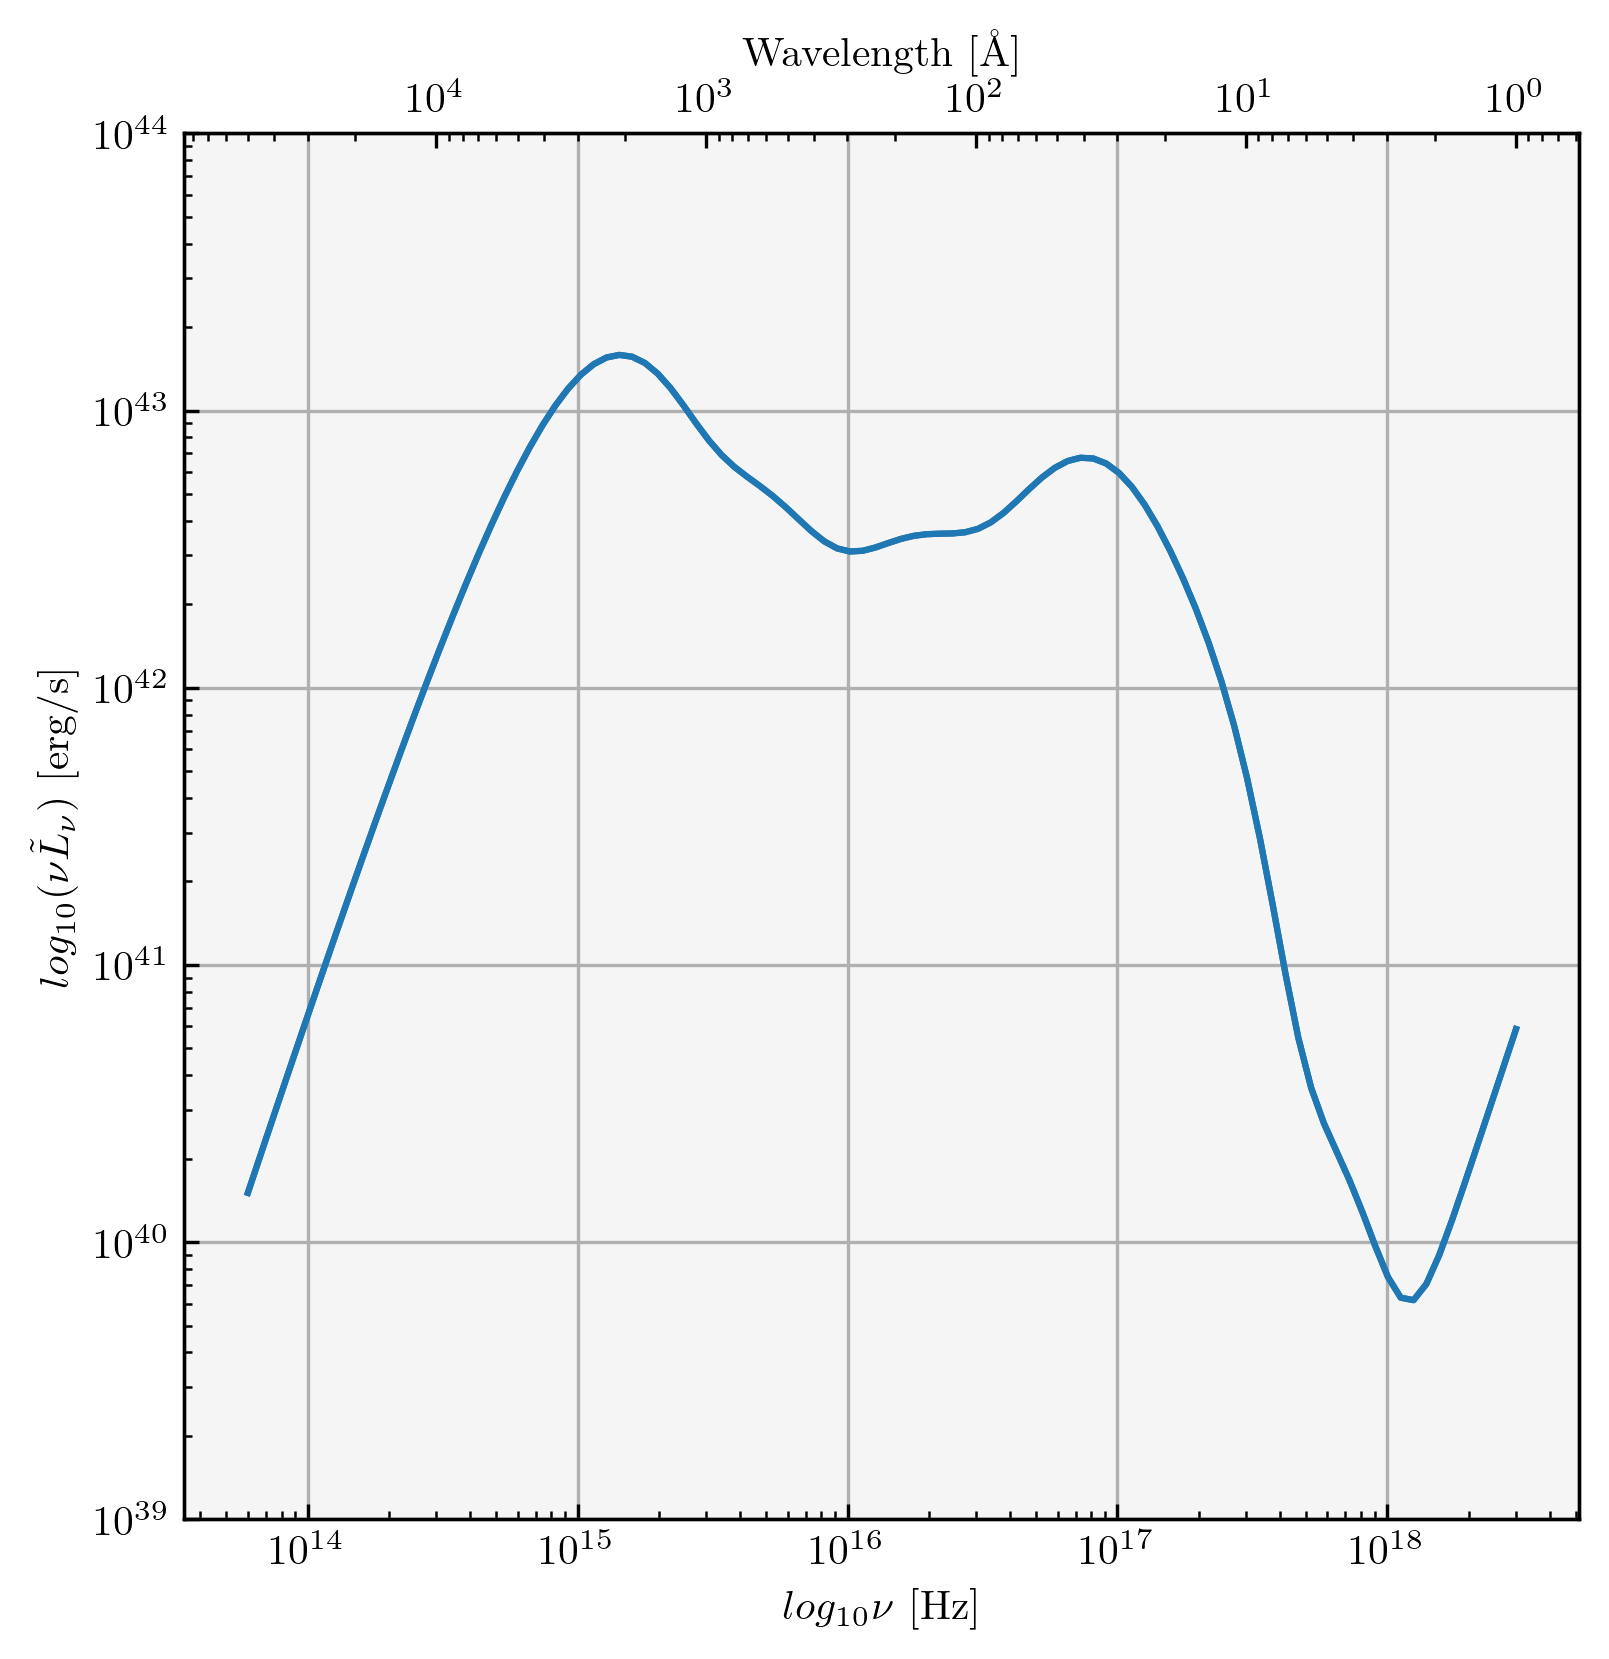

In [3]:
plt.figure( figsize=(4,5))


fig, ax1 = plt.subplots( figsize = (6,6) )
ax1.plot(n_arr, n_arr * lum_tilde_n)
ax2 = ax1.twiny()
ax1.set_xlabel(r'$log_{10}\nu$ [Hz]')
ax1.set_ylabel(r'$log_{10}(\nu\tilde{L}_\nu)$ [erg/s]')
ax1.loglog()
ax1.grid()
wavelength = np.divide(c, n_arr) * 1e8 # A
ax2.plot(wavelength, n_arr * lum_tilde_n)
ax2.invert_xaxis()
ax2.loglog()
ax2.set_xlabel(r'Wavelength [\AA]')
plt.ylim(1e39,1e44)
#plt.savefig('Figs/n_Ltildan_m' + str(m) + '_snap' + str(fix))
plt.show()